## Facial keypoint Detection


This project will be all about defining and training a convolutional neural network to perform facial keypoint detection, and using computer vision techniques to transform images of faces. The first step in any challenge like this will be to load and visualize the data you'll be working with.

<img src='images/key_pts_example.png' width=50% height=50%/>

Facial keypoints (also called facial landmarks) are the small magenta dots shown on each of the faces in the image above. In each training and test image, there is a single face and 68 keypoints, with coordinates (x, y), for that face. These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. These keypoints are relevant for a variety of tasks, such as face filters, emotion recognition, pose recognition, and so on. Here they are, numbered, and you can see that specific ranges of points match different portions of the face.
<img src='images/landmarks_numbered.jpg' width=30% height=30%/>

In [10]:
# import dependencies
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [11]:
key_point_frame=pd.read_csv('data/training_frames_keypoints.csv')

image_name=key_point_frame.iloc[0,0]
key_pts=key_point_frame.iloc[0,1:].as_matrix()
key_pts=key_pts.astype('float').reshape(-1,2)

print('Image names: ',image_name,
     '\nLandmarks shape: ',key_pts.shape,
     '\nFirst 4 key Points: ',key_pts[:4])


Image names:  Luis_Fonsi_21.jpg 
Landmarks shape:  (68, 2) 
First 4 key Points:  [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [12]:
print('No of images: ',key_point_frame.shape[0])

No of images:  3462


In [13]:
def show_keypoints(image,key_pts):
    plt.imshow(image)
    plt.scatter(key_pts[:,0],key_pts[:,1],s=20,marker='.',c='m')

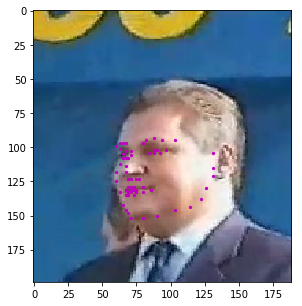

In [14]:
# select an image by random index
n=np.random.randint(0,key_point_frame.shape[0])
image_name=key_point_frame.iloc[n,0]
key_pts=key_point_frame.iloc[n,1:].as_matrix()
key_pts=key_pts.astype('float').reshape(-1,2)

plt.figure(figsize=(5,5))
show_keypoints(mpimg.imread(os.path.join('data/training/',image_name)),key_pts)
plt.show()

In [15]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [16]:
# Construct datasets
face_dataset=FacialKeypointsDataset('data/training_frames_keypoints.csv','data/training/')

print('Length of dataset :',len(face_dataset))

Length of dataset : 3462


0     585     (241, 253, 3)     (68, 2)
1     996     (120, 121, 3)     (68, 2)
2     1974     (200, 154, 3)     (68, 2)


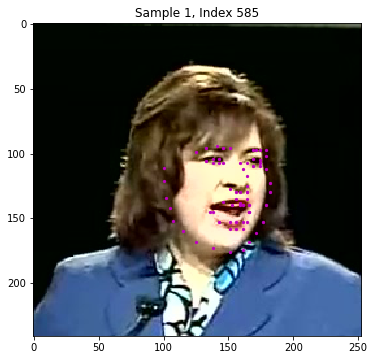

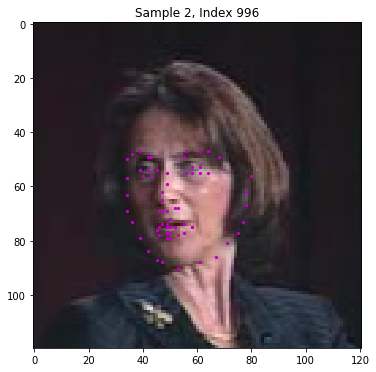

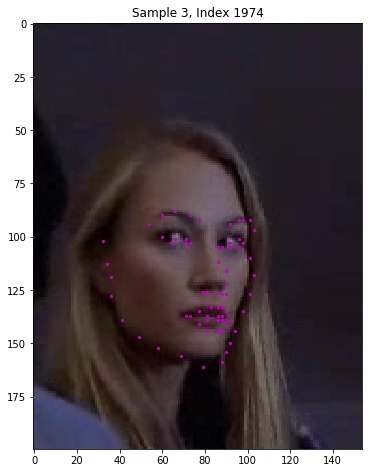

In [20]:
# Display few images
num_to_display=3
for i in range(num_to_display):
    
    fig=plt.figure(figsize=(20,10))
    
    #randomly select 
    idx=np.random.randint(0,len(face_dataset))
    sample=face_dataset[idx]
    
    
    print(i,'   ',idx,'   ',sample['image'].shape,'   ',sample['keypoints'].shape)
    
    ax=plt.subplot(1,num_to_display,i+1)
    ax.set_title('Sample {}, Index {}'.format(i+1,idx))
    
    show_keypoints(sample['image'],sample['keypoints'])

### Transform

In [21]:
import torch
from torchvision import transforms,utils


class Normalize(object):
    
    def __call__(self,sample):
        image,key_pts=sample['image'],sample['keypoints']
        
        image_copy=np.copy(image)
        key_pts_copy=np.copy(key_pts)
        
        # Convert image to gray scale
        image_copy=cv2.cvtColor(image_copy,cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0,255] to [0,1]
        image_copy=image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1,1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy=(key_pts_copy-100)/50
        
        return {'image':image_copy,'keypoints':key_pts_copy}
    
    
class Rescale(object):
    
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    
    def __init__(self,output_size):
        assert isinstance(output_size,(int,tuple))
        self.output_size=output_size
        
    def __call__(self,sample):
        
        image,key_pts=sample['image'],sample['keypoints']
        
        h,w=image.shape[:2]
        
        if isinstance(self.output_size,int):
            
            if h>w:
                new_h,new_w=self.output_size*h/w,self.output_size
            
            else:
                new_h,new_w=self.output_size,self.output_size*w/h
                
        else:
            new_h,new_w=self.output_size
            
        new_h,new_w=int(new_h),int(new_w)
        img=cv2.resize(image,(new_w,new_h))
        
        # Scale the pts, too
        key_pts=key_pts*[new_w/w,new_h/h]
        
        return {'image':img,'keypoints':key_pts}
    
class RandomCrop(object):
    
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    
    def __init__(self,output_size):
        assert isinstance(output_size,(int,tuple))
        
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self,sample):
        image,key_pts=sample['image'],sample['keypoints']
        
        h,w=image.shape[:2]
        new_h,new_w=self.output_size

        top=np.random.randint(0,h-new_h)
        left=np.random.randint(0,w-new_w)
        
        image=image[top:top+new_h,
                    left:left+new_w]
        
        key_pts=key_pts-[left,top]
        
        return {'image': image, 'keypoints': key_pts}
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)} 
        

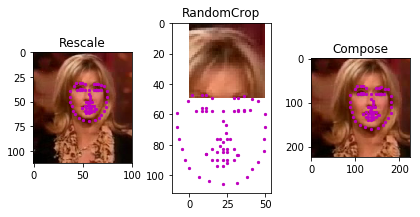

In [23]:
# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

test_num=500
sample=face_dataset[test_num]

fig=plt.figure()

for i,tx in enumerate([rescale,crop,composed]):
    
    transformed_sample=tx(sample)
    
    ax=plt.subplot(1,3,i+1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])
    
plt.show()

### Create the transformed datasets

In [24]:
# Define the data transform
data_transform=transforms.Compose([Rescale(250),
                                  RandomCrop(224),
                                  Normalize(),
                                  ToTensor()])

transformed_dataset=FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)

In [25]:
# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])
